# Competitive coevolution with DE

In [1]:
experiment_name = 'only_de'

In [2]:
import random
random.seed(456)

## Regex for test

In [3]:
input_regex = '((a|bb?)|(a|ba?)|([0-9]|.ab))'

params = {
    'range': ['0-9'],
    'repeat': ['0,1'],
}
    
nodes = {
    # functions (except any)
    -1: 'params', 
    0: 'seq', 
    1: 'atom', 
    2: 'any', 
    3: 'repeat', 
    4: 'alt', 
    5: 'altgroup', 
    6: 'group', 
    7: 'range', 
    8: 'escape', 

    # terminals (get by input regex)
    9: 'a', 
    10: 'b',
}

In [4]:
from coevolutionary.utils import Utils
from coevolutionary.utils import regex_process

test_strings = Utils.get_test_strings(
    input_regex=input_regex,
    n_fuzzy_strings=5
)

X, Y = Utils.create_training_set(
    test_strings=test_strings,
    original_regex=input_regex,
    process_func=regex_process,
)  

## Run

In [5]:
from coevolutionary.manager import CompetitiveManager
from coevolutionary.algorithms.de import DEAlgorithm

In [6]:
cm = CompetitiveManager(
    adaptive_interval=2,
    shared_resource=5_000,
    verbose=False,
    problem='min',
    survive_schema='best',
    social_card=0.3,
    penalty=0.10,
    experiment_name=experiment_name,
)

In [7]:
params_cases = [
    {'ndim': 10 * 2, 'bounds': [0, 10], 'cr': 0.45, 'f': 1.6, 'mu': 100},
    {'ndim': 15 * 2, 'bounds': [0, 10], 'cr': 0.45, 'f': 1.6, 'mu': 100},
    {'ndim': 10 * 2, 'bounds': [0, 10], 'cr': 0.3, 'f': 0.8, 'mu': 100},
    {'ndim': 15 * 2, 'bounds': [0, 10], 'cr': 0.3, 'f': 0.8, 'mu': 100},
]
algorithm_names = []

### Run algorithms in coevolution

In [8]:
for i, case in enumerate(params_cases):
    de_object = DEAlgorithm(
        nodes=nodes,
        params=params,
        X=X,
        Y=Y,
        n_iter=100
    )
    
    cm.add_algorithm(
        name=f'de_{i}_coev',
        init_params=case,
        init_algorithm=de_object.init_algorithm,
        init_population=de_object.init_population,
        get_fitness_population=de_object.get_fitness_population,
        select_population=de_object.select_population,
        recombine_population=de_object.recombine_population,
        mutate_population=de_object.mutate_population,
    )

In [9]:
cm.run_coevolution()

Done in 9.446 seconds


In [10]:
coevolution_algorithm_history = cm.algorithm_history
population_qualities_history = cm.population_qualities_history
coev_names = cm.get_algorithm_names()
best_alg_statistics = cm.get_winner_statistics()

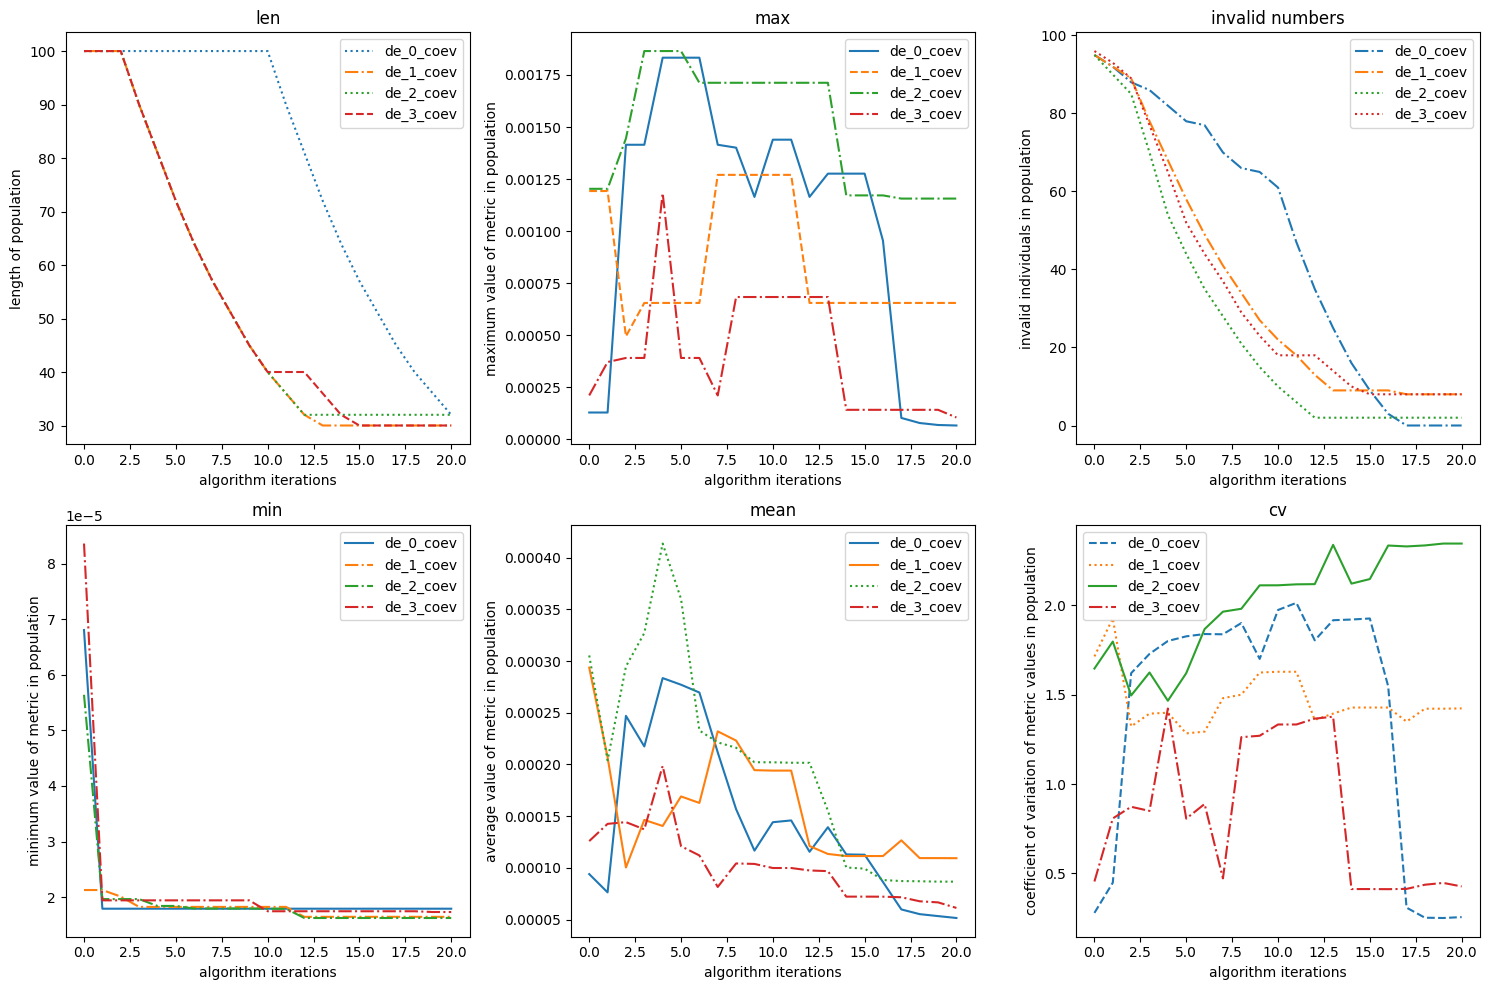

In [11]:
from coevolutionary.utils.visualization import visualize

visualize(
    algorithm_history=coevolution_algorithm_history,
    algorithm_names=coev_names
)

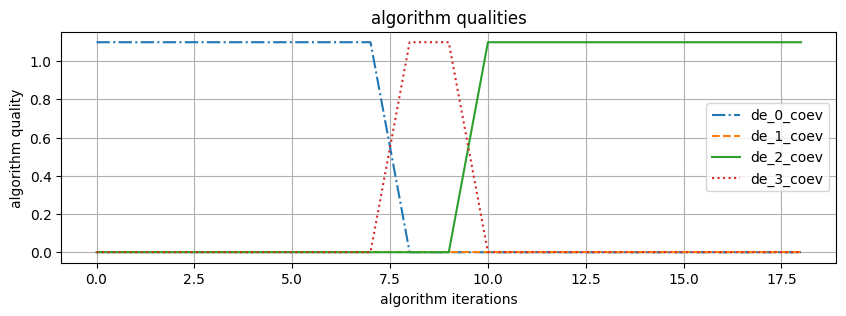

In [12]:
import matplotlib.pyplot as plt
from coevolutionary.utils.visualization import visualize_algorithms_quality

plt.rcParams["figure.figsize"] = (10, 3)
visualize_algorithms_quality(
    population_qualities_history=population_qualities_history,
    algorithm_names=coev_names
)

In [13]:
print('Best individual:', cm.get_best_individual())

Best individual: ('.()..', 1.6239975708760794e-05)


### Run algorithms separately

In [14]:
separately_algorithm_history = {}
sep_names = []

In [15]:
from coevolutionary.utils.tests import check_wilcoxon

for i, case in enumerate(params_cases):
    cm = CompetitiveManager(
        adaptive_interval=2,
        shared_resource=5_000,
        verbose=False,
        problem='min',
        survive_schema='best',
        social_card=0.3,
        penalty=0.10,
        experiment_name=experiment_name,
    )
    
    de_object = DEAlgorithm(
        nodes=nodes,
        params=params,
        X=X,
        Y=Y,
        n_iter=100
    )
    
    cm.add_algorithm(
        name=f'de_{i}_sep',
        init_params=case,
        init_algorithm=de_object.init_algorithm,
        init_population=de_object.init_population,
        get_fitness_population=de_object.get_fitness_population,
        select_population=de_object.select_population,
        recombine_population=de_object.recombine_population,
        mutate_population=de_object.mutate_population,
    )
    
    # overload run
    cm.run_coevolution()
    
    separately_algorithm_history[i] = cm.algorithm_history[0]
    sep_names.append(f'de_{i}_sep')
    
    print('\nBest individual: ', cm.get_best_individual())
    
    check_wilcoxon(
        history_a=cm.algorithm_history,
        history_b=best_alg_statistics,
        a_name=f'de_{i}_sep',
        b_name=f'best of coevolutionary de',
        a_index=0,
        b_index=i,
        metric_number=1,
        metric_name='minimum'
    )

Done in 9.441 seconds

Best individual:  ('...', 1.7962025779099028e-05)
The Wilcoxon test for minimum metric
	✓ According to the Wilcoxon test de_0_sep and best of coevolutionary de are different

Done in 6.375 seconds

Best individual:  ('.{0,1}..()', 1.772292525856756e-05)
The Wilcoxon test for minimum metric
	✓ According to the Wilcoxon test de_1_sep and best of coevolutionary de are different

Done in 13.036 seconds

Best individual:  ('.(a).', 1.6425111805548587e-05)
The Wilcoxon test for minimum metric
	✓ According to the Wilcoxon test de_2_sep and best of coevolutionary de are different

Done in 7.663 seconds

Best individual:  ('...', 1.7951431248006944e-05)
The Wilcoxon test for minimum metric
	✓ According to the Wilcoxon test de_3_sep and best of coevolutionary de are different



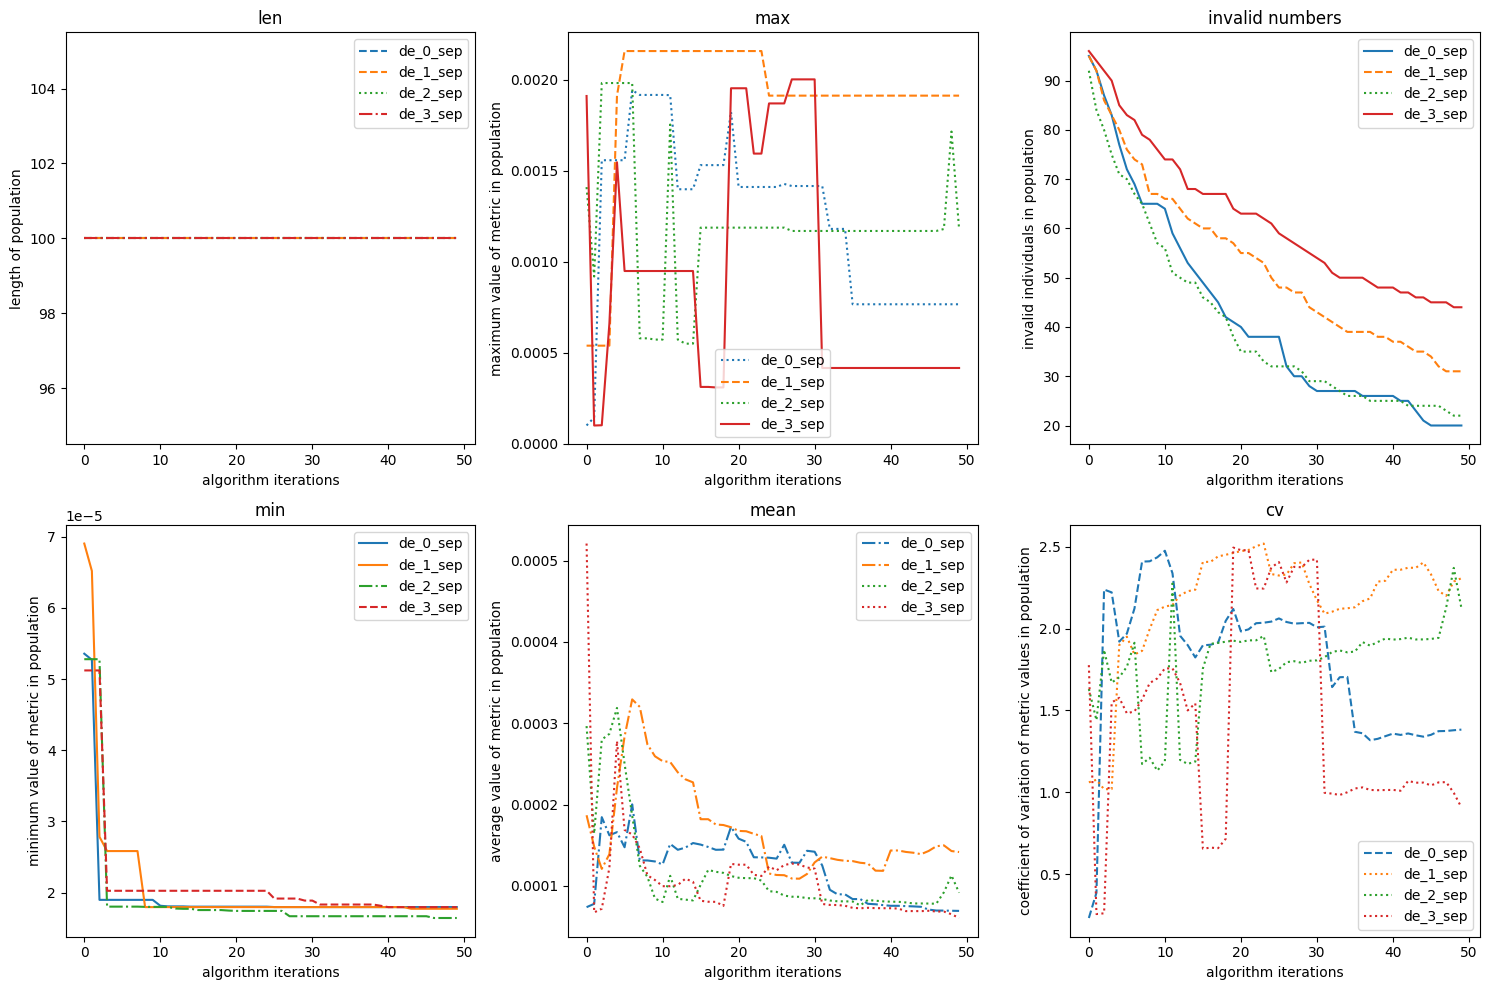

In [16]:
from coevolutionary.utils.visualization import visualize

plt.rcParams["figure.figsize"] = (15, 10)
visualize(
    algorithm_history=separately_algorithm_history,
    algorithm_names=sep_names
)